To open notebook in Colab please click below:
<a href="https://colab.research.google.com/github/bwolfson2/foster_2020/blob/master/Module7_Similarity_Clusters/clustering.ipynb" target="_parent"> <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" /> </a>'

In [0]:
#changing here
#If opening in colab run this cell
!git clone https://github.com/bwolfson2/foster_2020
%cd foster_2020/Module7_Similarity_Clusters

Cloning into 'foster_2020'...
remote: Enumerating objects: 175, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 284 (delta 54), reused 147 (delta 27), pack-reused 109
Receiving objects: 100% (284/284), 59.55 MiB | 21.43 MiB/s, done.
Resolving deltas: 100% (93/93), done.
Checking out files: 100% (120/120), done.
/content/foster_2020/Module7_Similarity_Clusters/foster_2020/Module7_Similarity_Clusters


# Similarity, Neighbors, and Clustering


Spring 2020 - Instructors: Foster Provost and Ben Wolfson

Teaching Assistant: Ben Wolfson
***

In [0]:
# Import the libraries we will be using
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
from scipy.spatial import distance
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.model_selection import cross_val_score
from collections import defaultdict

import sys
sys.path.append("..")
from ds_utils.decision_surface import *

sns.set(font_scale=1.5)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Lights, camera, action!

You've been hired by Netflakes as a business analytics professional. Netflakes' primary business is its subscription-based streaming service which offers online streaming of a library of films and television programs, including those produced in-house (sounds familiar?). A major competitive advantage of Netflakes is its wide variety of films. You've been hired to understand what kind of movies people like. Hopefully, your analysis will inspire ideas for new movies! 

Let's start by taking a look at the data we have available.

In [0]:
# Import the ratings dataset
df_ratings = pd.read_csv('data/ratings.csv')
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [0]:
# Import movies dataset
df_movies = pd.read_csv('data/movies.csv')
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [0]:
print('The dataset contains: ', len(df_ratings), ' ratings of ', len(df_movies), ' movies.')

The dataset contains:  100836  ratings of  9742  movies.


In [0]:
# Replace name of (no genres listed)
df_movies.genres = df_movies.genres.replace("(no genres listed)", "NA")
# Counts per genre (films may appear in more than one genre)
pd.Series(df_movies.genres.str.cat(sep="|").split("|")).value_counts()

Drama          4361
Comedy         3756
Thriller       1894
Action         1828
Romance        1596
Adventure      1263
Crime          1199
Sci-Fi          980
Horror          978
Fantasy         779
Children        664
Animation       611
Mystery         573
Documentary     440
War             382
Musical         334
Western         167
IMAX            158
Film-Noir        87
NA               34
dtype: int64

## Toward a feature representation - Let's explore the movie ratings data
How might we turn these ratings into a useful representation of user tastes (ideally, a feature vector where the instance is a user)?


### Avg. Ratings
One way is to define each feature vector as the average rating for each genre. 

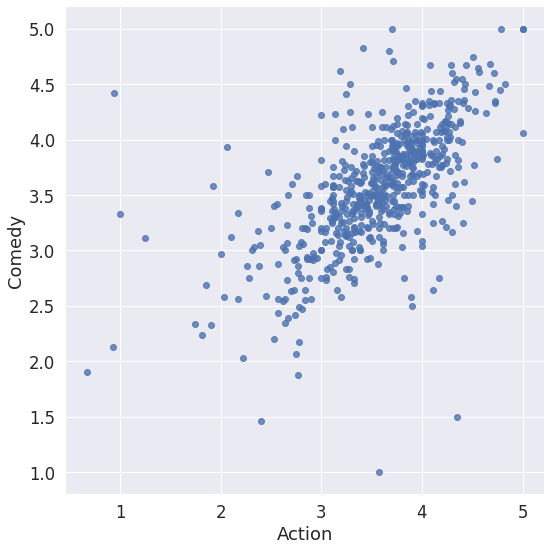

In [0]:
def get_genre_ratings(ratings, movies, genres, mean=True):
    all_genre_df = pd.DataFrame()
    for genre in genres:        
        genre_movies = movies[movies['genres'].str.contains(genre)]
        relevant_ratings = ratings[ratings['movieId'].isin(genre_movies['movieId'])]
        if mean is True:
            single_genre_df = relevant_ratings.groupby(['userId'])['rating'].mean().round(2)
        else:
            single_genre_df = relevant_ratings.groupby(['userId'])['rating'].count()
        all_genre_df = pd.concat([all_genre_df, single_genre_df], axis=1)
    all_genre_df.columns = genres
    return all_genre_df

genres = ['Action', 'Comedy']
users_by_avg_genre_ratings = get_genre_ratings(df_ratings, df_movies, genres)
sns.lmplot(genres[0], genres[1], data=users_by_avg_genre_ratings, fit_reg=False, height=8)
plt.show()

Here, each point is a user.  Users' genre ratings seem to be positively correlated. Why do you think that's so?

### Number of ratings
Let's try as features the total numbers of movies of each genre that a user has rated.

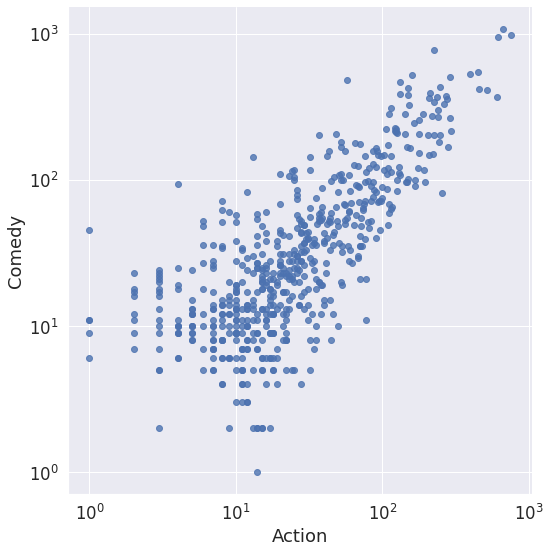

In [0]:
genres = ['Action', 'Comedy']
users_by_total_genre_ratings = get_genre_ratings(df_ratings, df_movies, genres, False)
grid = sns.lmplot(genres[0], genres[1], data=users_by_total_genre_ratings, fit_reg=False, height=8)
grid.set(xscale="log", yscale="log")
plt.show()

Users' genre counts seem correlated as well, why?

### Percentage of ratings
What if we instead define the feature vector as the percentage of ratings belonging to each genre?

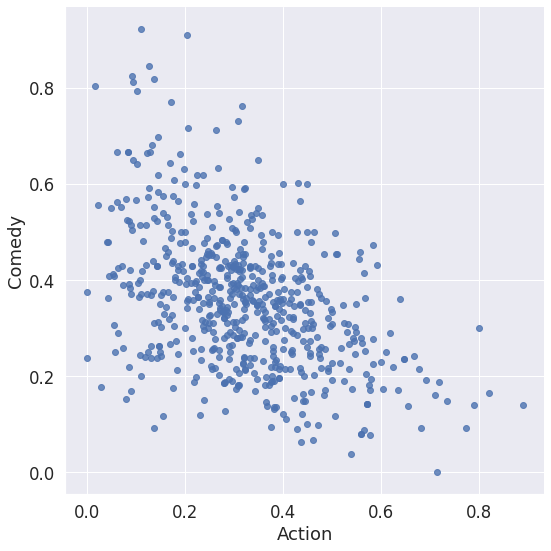

In [0]:
def get_genre_shares(ratings, movies):
    all_genres = np.unique(df_movies.genres.str.cat(sep="|").split("|"))
    all_genre_df = pd.DataFrame()
    for genre in all_genres:
        genre_movies = movies[movies['genres'].str.contains(genre)]
        relevant_ratings = ratings[ratings['movieId'].isin(genre_movies['movieId'])]
        single_genre_df = relevant_ratings.loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].count()
        all_genre_df = pd.concat([all_genre_df, single_genre_df], axis=1)
    # Get shares
    all_genre_df.columns = all_genres
    all_genre_df.fillna(0, inplace=True)
    all_genre_df = all_genre_df.div(ratings.groupby('userId').rating.count(), axis=0)
    return all_genre_df

genres = ['Action', 'Comedy']
users_by_rating_per = get_genre_shares(df_ratings, df_movies)
sns.lmplot(genres[0], genres[1], data=users_by_rating_per, fit_reg=False, height=8)
plt.show()

In [0]:
df_total = df_ratings.merge(df_movies,on="movieId")

Now we see different correlations. Why are action and comedy now anticorrelated?

Note: Percentages add up to more than 100, because some movies are in more than 1 Genre.

## Similarity measures

Once we have objects represented as data, we can compute the similarity between different objects. Each of the users is now described by their tastes for different genres. Let's keep using the share of ratings representation for now.

In [0]:
users_by_rating_per.head()

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,NA,Romance,Sci-Fi,Thriller,War,Western
1,0.387931,0.366379,0.125000,0.181034,0.357759,0.193966,0.000000,0.293103,0.202586,0.004310,0.073276,0.000000,0.094828,0.077586,0.0,0.112069,0.172414,0.237069,0.094828,0.030172
2,0.379310,0.103448,0.000000,0.000000,0.241379,0.344828,0.103448,0.586207,0.000000,0.000000,0.034483,0.137931,0.000000,0.068966,0.0,0.034483,0.137931,0.344828,0.034483,0.034483
3,0.358974,0.282051,0.102564,0.128205,0.230769,0.051282,0.000000,0.410256,0.102564,0.000000,0.205128,0.000000,0.025641,0.025641,0.0,0.128205,0.384615,0.179487,0.128205,0.000000
4,0.115741,0.134259,0.027778,0.046296,0.481481,0.125000,0.009259,0.555556,0.087963,0.018519,0.018519,0.004630,0.074074,0.106481,0.0,0.268519,0.055556,0.175926,0.032407,0.046296
5,0.204545,0.181818,0.136364,0.204545,0.340909,0.272727,0.000000,0.568182,0.159091,0.000000,0.022727,0.068182,0.113636,0.022727,0.0,0.250000,0.045455,0.204545,0.068182,0.045455


 So ... how can we tell if users have similar tastes? 
 
Generally, how can we compute similarity between users?  We take the most common approach: reduce this question to, *how can we compute similarity between objects described as feature vectors*.

There are many similarity measures.  Similarity is often cast as "closeness" in some space, as computed by a distance measure.  Often in data science, the terms similarity and distance are used interchangeably (which can be a little strange to the uninitiated). 

We'll use the library scipy.spatial.distance available [here](http://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

This library has functions to compute the distance between two numeric vectors. In particular, **pdist(X[, metric, p, w, V, VI])**	computes pairwise distances between the observations in n-dimensional space. The "metric parameter" is the distance function, which can be _‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘cityblock’, ‘correlation’, ‘cosine’, ‘dice’, ‘euclidean’, ‘hamming’, ‘jaccard’, ‘kulsinski’, ‘mahalanobis’, ‘matching’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’._

Here is a function that will compute the distance using as many metrics as you want:

In [0]:
def user_distance(users, userId, distance_measures, n):
    # - this will give the closest users to user userId
    # - distance_measures is a list of the distance measures you want to compute (see below)
    # - n is how many "most similar" to report
    #
    # - we want a data frame to store the output
    distances = pd.DataFrame()
    # Find the location of the user we are looking for
    user_location = np.where(users.index == userId)[0][0]
    # Go through all distance measures we care about
    for distance_measure in distance_measures:
        # Find all pairwise distances
        current_distances = distance.squareform(distance.pdist(users, distance_measure))
        # Get the closest n elements for the user we care about
        most_similar = np.argsort(current_distances[:, user_location])[0:n]
        # Append results (a new column to the dataframe with the name of the measure)
        distances[distance_measure] = list(zip(users.index[most_similar], current_distances[most_similar, user_location]))
    return distances

We can use the function `user_distance` to find the distance value of each user with respect to others. We'll start using Euclidean distance--which is by far the most commonly used distance metric:

In [0]:
user_distance(users_by_rating_per, 1, ['euclidean'], 6) #Find the users closest to User 1 based on Euclidean distance

,euclidean
0,"(1, 0.0)"
1,"(63, 0.177095592472526)"
2,"(328, 0.18049125683427292)"
3,"(230, 0.19113395988090962)"
4,"(212, 0.1915820018819835)"
5,"(559, 0.1954084262054854)"


Now, let's use more metrics.

In [0]:
user_distance(users_by_rating_per, 1, ['euclidean', 'cityblock', 'cosine', 'correlation'], 10)

,euclidean,cityblock,cosine,correlation
0,"(1, 0.0)","(1, 0.0)","(1, 0.0)","(1, 0.0)"
1,"(63, 0.177095592472526)","(328, 0.5777045300878973)","(63, 0.02007259654154736)","(63, 0.0471673266390521)"
2,"(328, 0.18049125683427292)","(212, 0.5998331479421579)","(328, 0.020879378014718397)","(67, 0.04774478550878669)"
3,"(230, 0.19113395988090962)","(478, 0.6242163009404389)","(230, 0.02286313548795027)","(559, 0.05127801917479913)"
4,"(212, 0.1915820018819835)","(63, 0.6383604784323705)","(212, 0.02303528954305223)","(328, 0.05275220925130786)"
5,"(559, 0.1954084262054854)","(230, 0.6507380302654429)","(559, 0.02461178747405779)","(212, 0.05312075731053212)"
6,"(478, 0.20577772020068938)","(308, 0.6938905547226387)","(382, 0.026287795853424445)","(230, 0.05577719318647012)"
7,"(240, 0.20749936036407723)","(559, 0.6979064039408867)","(478, 0.026535197553909207)","(382, 0.05859047293540831)"
8,"(382, 0.20955448226960666)","(217, 0.7260997356134329)","(67, 0.026811159912045524)","(217, 0.06241298973945364)"
9,"(592, 0.2127416253764623)","(171, 0.7265559293523969)","(394, 0.028080365146211483)","(592, 0.06264741383518513)"


In [0]:
users_by_rating_per.loc[[1, 63, 328, 212]].sort_values(by=1, axis=1, ascending=False)

,Action,Adventure,Comedy,Drama,Thriller,Fantasy,Crime,Children,Sci-Fi,Animation,Romance,War,Musical,Mystery,Horror,Western,Film-Noir,NA,IMAX,Documentary
1,0.387931,0.366379,0.357759,0.293103,0.237069,0.202586,0.193966,0.181034,0.172414,0.125000,0.112069,0.094828,0.094828,0.077586,0.073276,0.030172,0.004310,0.000000,0.000000,0.000000
63,0.398524,0.328413,0.405904,0.350554,0.254613,0.140221,0.206642,0.110701,0.214022,0.121771,0.121771,0.059041,0.036900,0.077491,0.044280,0.003690,0.018450,0.000000,0.077491,0.025830
328,0.313725,0.360784,0.384314,0.341176,0.196078,0.207843,0.184314,0.235294,0.184314,0.200000,0.137255,0.047059,0.109804,0.070588,0.047059,0.027451,0.003922,0.000000,0.098039,0.003922
212,0.435484,0.350806,0.350806,0.375000,0.221774,0.177419,0.189516,0.120968,0.205645,0.145161,0.096774,0.040323,0.024194,0.076613,0.056452,0.016129,0.004032,0.004032,0.112903,0.000000


## Clustering Methods

Similarity has many uses in data science.  One of the most commonly discussed is clustering: Can we find groups of users that are similar?

### Hierarchical Clustering

There are different ways to find similar groups.  One very common method is Hierarchical Clustering.

First let's look at a simple example to illustrate.  Given a set of records (A-F) with two features, we can visualize them on a 2 dimensional surface.  Clustering proceeds as follows.  First consider each point to be its own cluster.  Then, iteratively, group together the closest two clusters.  In the figure, circles were drawn in order of grouping.  The second diagram is a visualization of the hierarchy of groupings, called a "dendrogram."  You can clip it at any point, vertically, and get "the best" clustering for a certain number of groups.


<img src="https://github.com/bwolfson2/foster2020/blob/master/Module7_Similarity_Clusters/images/cutting.png?raw=1" height=40% width=40%>

Let's examine the dendrogram(s) for our data, we'll be using the library: **scipy.cluster.hierarchy**

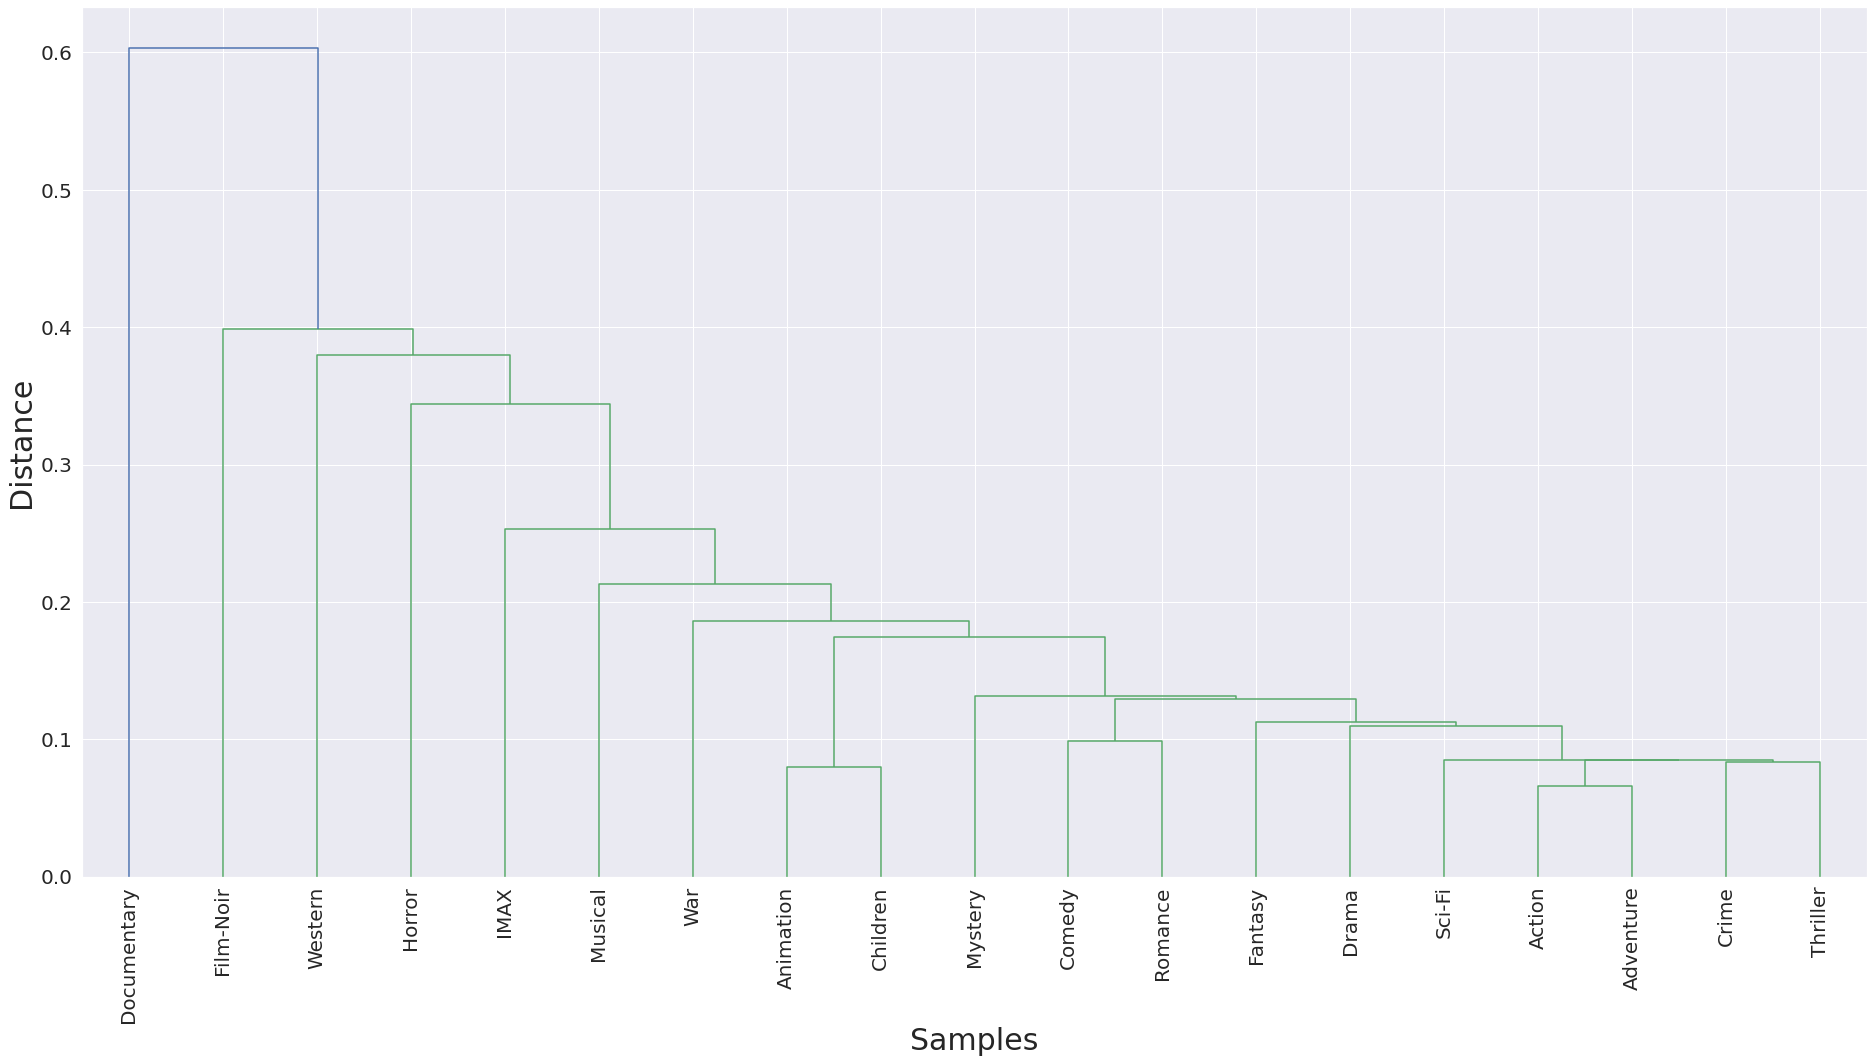

In [0]:
sample = users_by_rating_per.T
sample = sample.drop(["NA"],axis = 0)

# This function gets pairwise distances between observations in n-dimensional space (e.g., cosine, euclidean).
dists = distance.pdist(sample, metric="cosine")

# This scipy's function performs hierarchical/agglomerative clustering on the condensed distance matrix y.
# Method could be 'average' distance from points in cluster v to points in cluster w or the 'single' shortest distance
links = linkage(dists, method='single')

# Now we want to plot those 'links' using "dendrogram" function
plt.rcParams['figure.figsize'] = 32, 16

den = dendrogram(links, labels=sample.index)

plt.xlabel('Samples',fontsize=30)
plt.ylabel('Distance',fontsize=30)
plt.xticks(rotation=90,fontsize=20)
plt.yticks(fontsize=20)
plt.show()

It is common to cut dendrograms at a particular height and to then use the resulting clusters. However, watch out for two things when doing hierarchical clusters: (1) it does not scale well with large data sets and (2) it's very sensitive to outliers.

### KMeans

Another method for finding clusters is to use the KMeans algorithm to find a set of $k$ clusters. Here, unlike in hierarchical clustering, we define the number of clusters in advance. We'll use the library **sklearn.cluster**

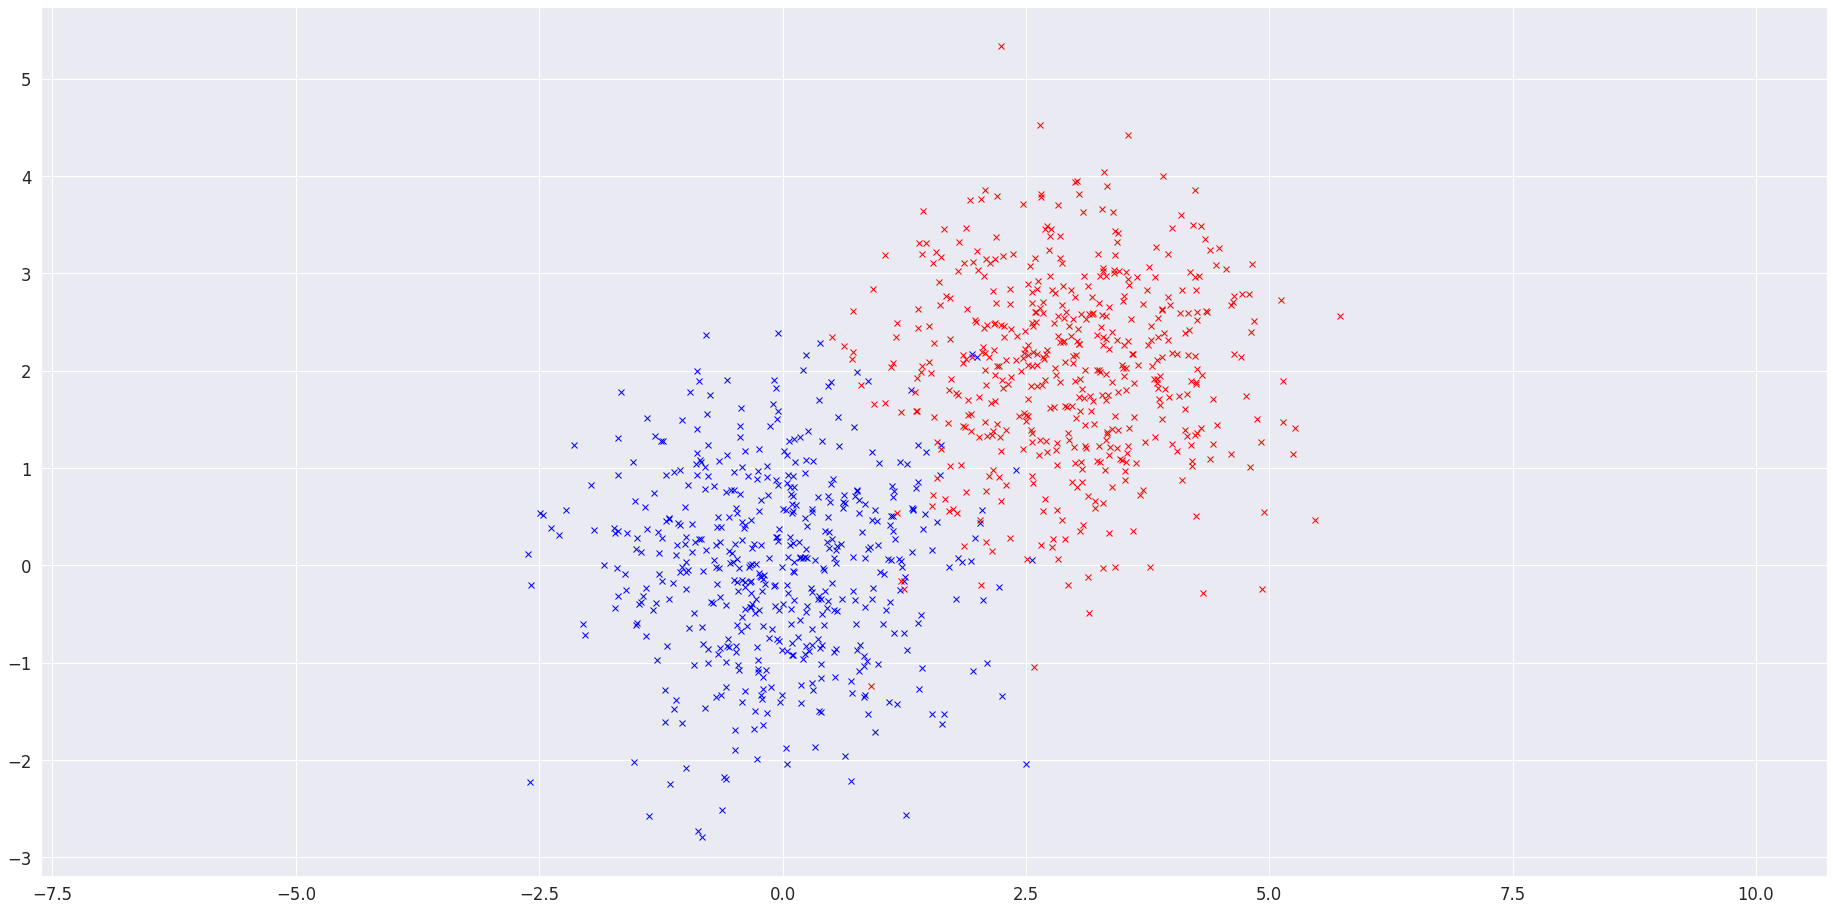

In [0]:
mean1 = [0,0]
cov1 = [[1,0],[0,1]]
mean2 = [3,2]
cov2 = [[1,0],[0,1]]
x1, y1 = np.random.multivariate_normal(mean1, cov1, 500).T
plt.plot(x1, y1, 'x',color="blue")
plt.axis('equal')
x2, y2 = np.random.multivariate_normal(mean2, cov2, 500).T
plt.plot(x2, y2, 'x',color="red")
x = np.concatenate([x1,x2])
y = np.concatenate([y1,y2])

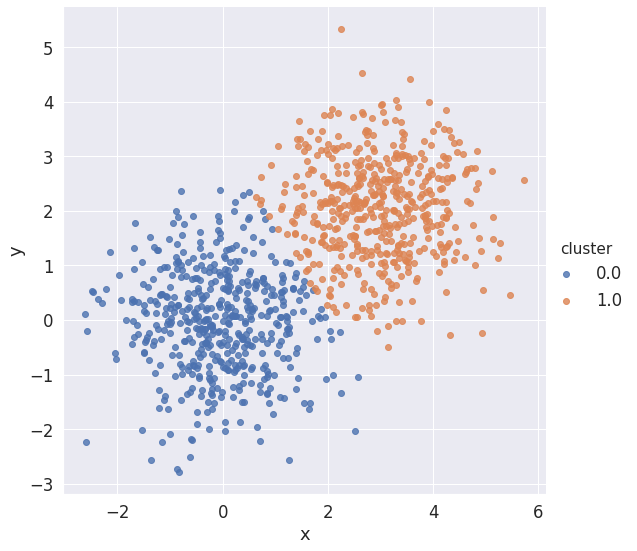

In [0]:
kmeans = KMeans(n_clusters=2, random_state=42)
X = np.column_stack([x,y])
kmeans.fit(X)
cluster = kmeans.predict(X)
cdf = pd.DataFrame([x,y,cluster]).T
cdf.columns = ["x","y","cluster"]
cdf
sns.lmplot("x", "y", data=cdf, hue='cluster', fit_reg=False, height=8)



array([-0.64543457,  1.68575956, -0.90450081, ...,  2.16468134,
        1.93233869,  1.62144352])

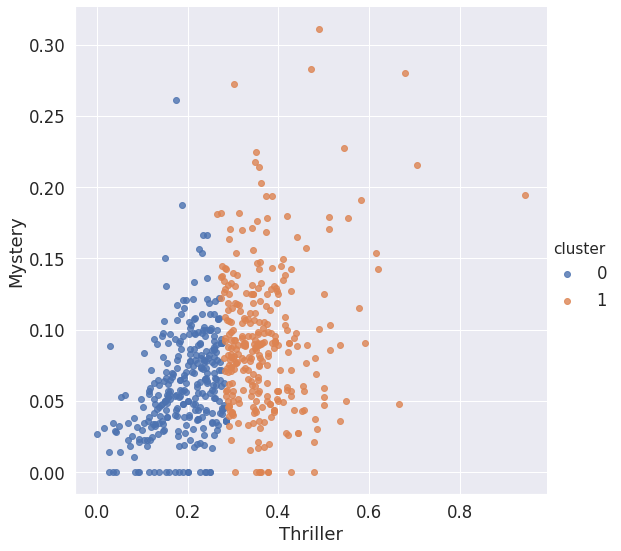

In [0]:
k_clusters = 2
kmeans = KMeans(n_clusters=k_clusters, random_state=42)
genres = ['Thriller', 'Mystery']
kmeans.fit(users_by_rating_per[genres])
users_by_rating_per['cluster'] = kmeans.predict(users_by_rating_per[genres])
sns.lmplot(genres[0], genres[1], data=users_by_rating_per, hue='cluster', fit_reg=False, height=8)
plt.show()

We are using euclidean distance to find these clusters. Do you have any concerns about this?

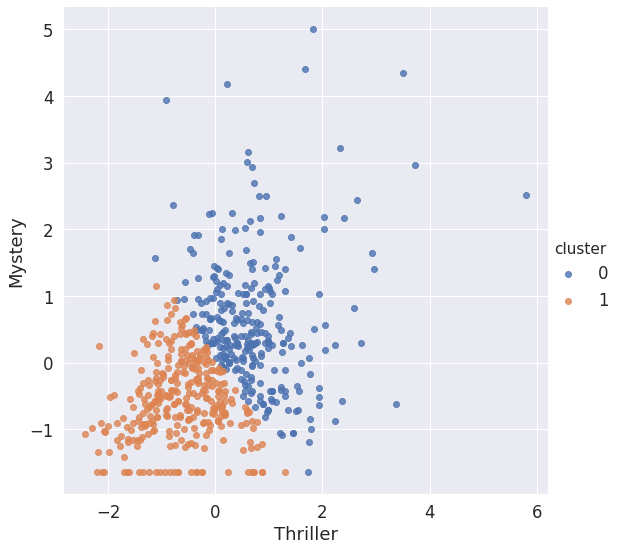

In [0]:
df_normalized_genre = (users_by_rating_per - users_by_rating_per.mean())/users_by_rating_per.std()
k_clusters = 2
kmeans = KMeans(n_clusters=k_clusters, random_state=42)
genres = ['Thriller', 'Mystery']
kmeans.fit(df_normalized_genre[genres])
df_normalized_genre['cluster'] = kmeans.predict(df_normalized_genre[genres])
sns.lmplot(genres[0], genres[1], data=df_normalized_genre, hue='cluster', fit_reg=False, height=8)
plt.show()

KMeans is very sensitive to scale and will tend to cluster according to the features with greater variance.

What happens if we use all the genres to cluster users?

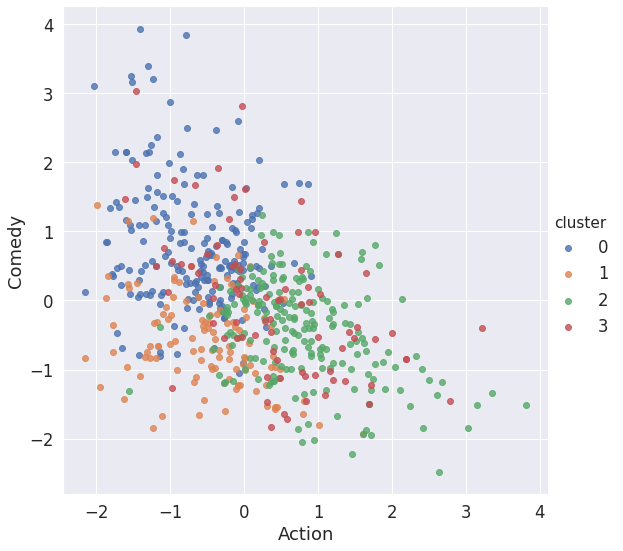

In [0]:
kmeans = KMeans(n_clusters=4, random_state=42)
all_genres = df_normalized_genre.columns[df_normalized_genre.columns != 'cluster']
genres = ['Action', 'Comedy']
df_normalized_genre['cluster'] = kmeans.fit_predict(df_normalized_genre[all_genres]).astype(int)
sns.lmplot(genres[0], genres[1], data=df_normalized_genre, hue='cluster', fit_reg=False, height=8)
plt.show()

We can't *really* visualize them in 2 dimensions. For example, what's up with red cluster (#3)?

How can we describe or name each cluster?

In [0]:
centroids = df_normalized_genre.groupby('cluster').mean()
centroids

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,NA,Romance,Sci-Fi,Thriller,War,Western
cluster,,,,,,,,,,,,,,,,,,,,
0,-0.672874,-0.492830,-0.072219,0.099441,0.786363,-0.460507,-0.053575,0.044082,-0.083544,-0.204869,-0.144320,-0.376920,0.397860,-0.430609,-0.089127,0.828663,-0.560103,-0.584401,-0.255485,0.078400
1,-0.510290,-0.834636,-0.552073,-0.674743,-0.567978,0.914353,0.566865,1.059308,-0.574747,0.983233,-0.080418,-0.291961,-0.544048,0.986890,-0.128045,-0.240442,-0.518631,0.342824,0.438718,-0.054968
2,0.793007,0.396673,-0.260322,-0.305166,-0.437067,0.220845,-0.225743,-0.339796,-0.172001,-0.215372,0.297276,0.090688,-0.290448,-0.037684,-0.107476,-0.558301,0.592917,0.658447,0.110658,0.107430
3,0.382338,1.404741,1.626828,1.490643,-0.027663,-0.724780,-0.103571,-0.758660,1.463182,-0.349422,-0.282043,1.119649,0.528063,-0.246514,0.675965,-0.292197,0.622610,-0.712609,-0.274187,-0.388163


In [0]:
data = defaultdict(list)
top = 3

clusters = sorted(df_normalized_genre.cluster.unique())
for cluster in clusters:
    tastes = centroids.loc[cluster].sort_values()
    for i, t in enumerate(tastes[:top].index):
        data["Dislike {0}".format(i + 1)].append("{0}: {1}".format(t, tastes[t].round(2)))
    for i, t in enumerate(tastes[-top:][::-1].index):
        data["Like {0}".format(i + 1)].append("{0}: {1}".format(t, tastes[t].round(2)))
    counts = df_normalized_genre[df_normalized_genre.cluster == cluster].shape[0]
    data["count"].append(counts)
    
cols = ['count'] + ["Like {0}".format(i+1) for i in range(top)] + ["Dislike {0}".format(i+1) for i in range(top)]
cluster_info = pd.DataFrame(data)[cols].transpose()
cluster_info.columns = ["cluster {0}".format(i) for i in clusters]
cluster_info

,cluster 0,cluster 1,cluster 2,cluster 3
count,203,117,208,82
Like 1,Romance: 0.83,Drama: 1.06,Action: 0.79,Animation: 1.63
Like 2,Comedy: 0.79,Mystery: 0.99,Thriller: 0.66,Children: 1.49
Like 3,Musical: 0.4,Film-Noir: 0.98,Sci-Fi: 0.59,Fantasy: 1.46
Dislike 1,Action: -0.67,Adventure: -0.83,Romance: -0.56,Drama: -0.76
Dislike 2,Thriller: -0.58,Children: -0.67,Comedy: -0.44,Crime: -0.72
Dislike 3,Sci-Fi: -0.56,Fantasy: -0.57,Drama: -0.34,Thriller: -0.71


We could think of these as the "Happy Films", "Intense Action", "Sinister Drama", and "Cartoon Adventure" clusters. Perhaps we could use this information to help develop new films that would fit well with existing tastes. 

## Movie-level Clustering
Now that we've covered some ground regarding how Kmeans clusters **users** based on their genre tastes, let's take a different tack and look at the similarity of movies based on how users rated them. To do that, we'll look at the ratings organized by userId and movie. 

Let's look at a subset of the dataset:

In [0]:
# Merge the two tables then pivot so we have Users X Movies dataframe
ratings_title = pd.merge(df_ratings, df_movies[['movieId', 'title']], on='movieId')
df_user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')

print('dataset dimensions: ', df_user_movie_ratings.shape, '\n\nSubset example:')
df_user_movie_ratings.iloc[10:20, :10]

dataset dimensions:  (610, 9719) 

Subset example:


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987)
userId,,,,,,,,,,
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN
13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
19,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN


Ughh.  Look at all the NaNs.  Most users have not rated and watched most movies. The dominance of NaN values can be an important issue. Why?

Same as with text, this dataset is "sparse" -- only a small number of cells have actual values. To get around this, let's sort by the movies with the most ratings, and the users who have rated the most movies. That will present a more 'dense' region when we peek at the top of the dataset.

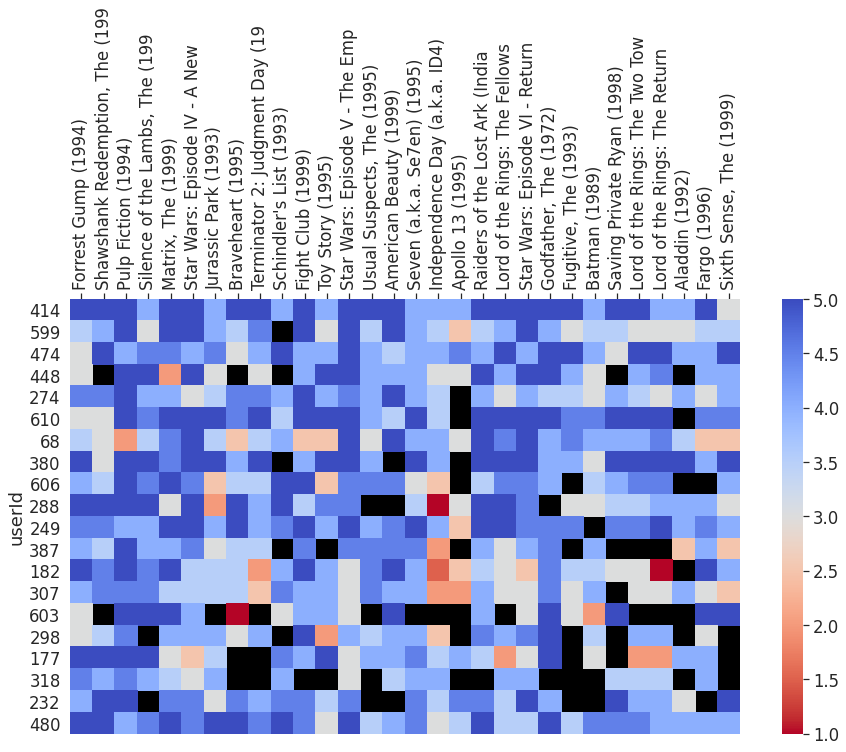

In [0]:
n_movies = 30
n_users = 20
top_movies = df_user_movie_ratings.count().sort_values()[-n_movies:].index[::-1]
top_users = df_user_movie_ratings.count(axis=1).sort_values()[-n_users:].index[::-1]
top_mat = df_user_movie_ratings.loc[top_users, top_movies]
plt.figure(figsize = (15,8))
shorter_titles = [c[:30] for c in top_mat.columns]
g = sns.heatmap(top_mat, cmap=plt.cm.coolwarm_r, xticklabels=shorter_titles)
g.xaxis.set_ticks_position('top')
plt.setp(g.get_xticklabels(), rotation=90)
plt.xlabel('')
g.set_facecolor('black')
plt.show()

Each column is a movie. Each row is a user. The color of the cell is how the user rated that movie based on the scale on the right of the graph.

Notice how some cells are black? This means the respective user did not rate that movie. This is an issue you may well run across when clustering in real life. Unlike the clean example we started with, many real-world datasets are sparse. This makes it less straightforward to cluster users directly by their movie ratings as distance metrics generally do not like missing values. Can you think what to do about it?

In [0]:
# Let's cluster people by the movies they watch
# We will keep the top 1000 movies to cluster people
n_movies = 1000
top_movieId = ratings_title.movieId.value_counts()[:1000].index
#only the ratings of the top 1000 movides
ratings_top_movies = ratings_title[np.in1d(ratings_title.movieId, top_movieId)]
# Create a sparse version of the Users X Movies dataframe. This will impute a value of 0 for missing data.
titles_c = np.array(sorted(ratings_top_movies.title.unique())) #unique sorted title
users_c = np.array(sorted(ratings_top_movies.userId.unique())) #unique sorted users
row = pd.Categorical(ratings_top_movies.userId, categories=users_c, ordered=True).codes #
col = pd.Categorical(ratings_top_movies.title, categories=titles_c, ordered=True).codes
ratings_top_movies
#fill with mean

sparse_ratings = csr_matrix((ratings_top_movies.rating, (row, col)), shape=(users_c.size, titles_c.size))

<610x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 61256 stored elements in Compressed Sparse Row format>

In [0]:
#import scipy
#random_matrix = scipy.sparse.random(sparse_ratings.shape[0],sparse_ratings.shape[1],density=1)*5
#random_matrix = random_matrix.tocsr()
#random_matrix[sparse_ratings > 0] = sparse_ratings[sparse_ratings > 0]


(1, 1000)

In [0]:
np.asarray(sparse_ratings.mean(axis=0).argsort()[0, -top:]).reshape(-1)

array([798, 578, 709, 338, 787])

Let's cluster by movies and take a look at the results! 

In [0]:
k_clusters = 20
kmeans = KMeans(n_clusters=k_clusters, random_state=42)
clusters = kmeans.fit_predict(sparse_ratings).astype(int)

data = defaultdict(list)
top = 5
for cluster in range(k_clusters):
    # sparse_ratings[clusters == cluster, :] all ratings for this cluster
    # .mean(axis=0) : finds the mean per movie
    # .argsort() : sorts matrix and returns the indices
    #  [0, -top:]) : selects the top indixes 
    # .reshape(-1) reshapes to an array (shape inferred)
    # so overall the function finds all the ratings in the cluster, gets their mean, and returns the top 5 in an an . array
    top_ixs = np.asarray(sparse_ratings[clusters == cluster, :].mean(axis=0).argsort()[0, -top:]).reshape(-1)
    #converts to movie title
    for i, ix in enumerate(top_ixs):
        data["Top {0} Movie".format(i + 1)].append(titles_c[ix])
    counts = clusters[clusters == cluster].size
    data["count"].append(counts)
    
cols = ['count'] + ["Top {0} Movie".format(i+1) for i in range(top)]
cluster_info = pd.DataFrame(data)[cols].transpose()
cluster_info.columns = ["cluster {0}".format(i) for i in range(k_clusters)]
cluster_info.iloc[:, cluster_info.loc['count'].argsort()[::-1]]

,cluster 12,cluster 5,cluster 6,cluster 13,cluster 4,cluster 17,cluster 1,cluster 9,cluster 3,cluster 7,cluster 16,cluster 11,cluster 19,cluster 14,cluster 18,cluster 2,cluster 10,cluster 8,cluster 15,cluster 0
count,249,93,60,48,42,27,24,21,12,5,5,5,4,4,3,3,2,1,1,1
Top 1 Movie,Fight Club (1999),Forrest Gump (1994),Dances with Wolves (1990),Raiders of the Lost Ark (Indiana Jones and the...,Braveheart (1995),Fight Club (1999),Pulp Fiction (1994),"Godfather, The (1972)","Fifth Element, The (1997)",Casino (1995),Monty Python and the Holy Grail (1975),American Beauty (1999),Up (2009),"Godfather, The (1972)",Star Wars: Episode V - The Empire Strikes Back...,Saving Private Ryan (1998),Léon: The Professional (a.k.a. The Professiona...,Aliens (1986),"Nightmare Before Christmas, The (1993)",Unbreakable (2000)
Top 2 Movie,Star Wars: Episode IV - A New Hope (1977),Pulp Fiction (1994),Braveheart (1995),Star Wars: Episode VI - Return of the Jedi (1983),"Lion King, The (1994)","Matrix, The (1999)",Star Wars: Episode V - The Empire Strikes Back...,"Silence of the Lambs, The (1991)",Office Space (1999),"Shawshank Redemption, The (1994)",Raiders of the Lost Ark (Indiana Jones and the...,Kill Bill: Vol. 2 (2004),"Shawshank Redemption, The (1994)",Rear Window (1954),Psycho (1960),"Usual Suspects, The (1995)",There Will Be Blood (2007),Spider-Man 2 (2004),Donnie Darko (2001),Caddyshack (1980)
Top 3 Movie,Forrest Gump (1994),"Shawshank Redemption, The (1994)","Shawshank Redemption, The (1994)",Terminator 2: Judgment Day (1991),Jurassic Park (1993),"Dark Knight, The (2008)",Fargo (1996),"Wizard of Oz, The (1939)",Fight Club (1999),Pulp Fiction (1994),Star Wars: Episode VI - Return of the Jedi (1983),Spirited Away (Sen to Chihiro no kamikakushi) ...,Juno (2007),Groundhog Day (1993),"Lord of the Rings: The Fellowship of the Ring,...","Shawshank Redemption, The (1994)",Looper (2012),Road to Perdition (2002),Monty Python's Life of Brian (1979),WALL·E (2008)
Top 4 Movie,"Matrix, The (1999)",Fight Club (1999),Pulp Fiction (1994),Star Wars: Episode IV - A New Hope (1977),Forrest Gump (1994),Forrest Gump (1994),Raiders of the Lost Ark (Indiana Jones and the...,Casablanca (1942),Forrest Gump (1994),Office Space (1999),Star Wars: Episode IV - A New Hope (1977),Fight Club (1999),Toy Story 3 (2010),Chinatown (1974),"Shawshank Redemption, The (1994)",American Beauty (1999),Star Wars: Episode IV - A New Hope (1977),Seven (a.k.a. Se7en) (1995),Eternal Sunshine of the Spotless Mind (2004),Howl's Moving Castle (Hauru no ugoku shiro) (2...
Top 5 Movie,"Shawshank Redemption, The (1994)","Matrix, The (1999)",Apollo 13 (1995),Star Wars: Episode V - The Empire Strikes Back...,"Fugitive, The (1993)",Star Wars: Episode IV - A New Hope (1977),Star Wars: Episode IV - A New Hope (1977),American Beauty (1999),"Matrix, The (1999)",Fight Club (1999),Star Wars: Episode V - The Empire Strikes Back...,Pulp Fiction (1994),V for Vendetta (2006),Apocalypse Now (1979),Schindler's List (1993),"Matrix, The (1999)",Raiders of the Lost Ark (Indiana Jones and the...,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Heathers (1989),(500) Days of Summer (2009)


Do the clusters seem reasonable?

## Nearest Neighbors: Recommending Movies

Imagine that we want to make movie recommendations to a user. Can we use similarity to do this? As an example, let's find the nearest neighbors to userId 1.

In [0]:
# Find k=10 nearest neighbors
k = 10
nn_model = NearestNeighbors(n_neighbors=k+1).fit(sparse_ratings)
distances, indices = nn_model.kneighbors(sparse_ratings[0,:])

Now, let's find the movies that were liked the most by userid 1's neighbors (most similar other users) by taking the average rating. 

In [0]:
indices

array([[  0, 492,  38, 576, 367,  95, 163, 531,  78, 207,  71]])

In [0]:
# Get average ratings for each movie according to nearest neighbors
# indices[0, 1:] indices of the neighbors
# sparse_ratings[indices[0, 1:] : ratings on the movies by those neighbors
avg_ratings = np.asarray(sparse_ratings[indices[0, 1:], :].mean(axis=0)).reshape(-1)
# Get top recommendations
k_rec = 10
top_recommendations = titles_c[avg_ratings.argsort()[::-1][:k_rec]]
# Check  whether the user has already seen these movies.
for title in top_recommendations:
    user_rating = df_user_movie_ratings.loc[1, title]
    if  pd.isnull(user_rating):
        print("RECOMMEND:", title)
    else:
        print("USER GAVE RATING", user_rating, "TO",  title)

RECOMMEND: Terminator 2: Judgment Day (1991)
RECOMMEND: Godfather, The (1972)
USER GAVE RATING 5.0 TO Matrix, The (1999)
USER GAVE RATING 4.0 TO Braveheart (1995)
RECOMMEND: Aliens (1986)
USER GAVE RATING 5.0 TO Star Wars: Episode VI - Return of the Jedi (1983)
USER GAVE RATING 5.0 TO Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
USER GAVE RATING 5.0 TO Star Wars: Episode IV - A New Hope (1977)
USER GAVE RATING 5.0 TO Indiana Jones and the Last Crusade (1989)
USER GAVE RATING 4.0 TO Saving Private Ryan (1998)


The nearest neighbors like Terminator 2. What if we wanted to predict how much the user would like this recommendation? How could we do that?

That's a supervised learning task. If we have a target variable to estimate/predict and labels for a training set,  we can do prediction directly using similarity.

In this case, our label would be the rating for the Terminator 2 movie. One way to use similarity to build a predictor<sup>&dagger;</sup> is to use a **Nearest Neighbor algorithm**.  The idea is: to predict the value of the target variable for a data item, first find the most similar (closest) training data items.  The **k-Nearest-Neighbor** or **kNN** algorithm chooses the closest `k` data points.  Then, gather the values of the target variable for these `k`, and then combines these values somehow.  So, to classify, one might combine them by having them vote their classes. (How would you combine to compute probability estimates? What about a regression problem?)

For now, let's take a look at the ratings of the top recommended movies for each nearest neighbor.

<sup>&dagger;</sup>There's an interesting question as to whether we're actually building a *model* here.

In [0]:
top_neighbors_movies = df_user_movie_ratings.iloc[indices[0, 1:]][top_recommendations] 
top_neighbors_movies

title,Terminator 2: Judgment Day (1991),"Godfather, The (1972)","Matrix, The (1999)",Braveheart (1995),Aliens (1986),Star Wars: Episode VI - Return of the Jedi (1983),Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),Star Wars: Episode IV - A New Hope (1977),Indiana Jones and the Last Crusade (1989),Saving Private Ryan (1998)
userId,,,,,,,,,,
493,4.0,5.0,5.0,5.0,4.0,NaN,4.0,5.0,3.0,4.0
39,4.0,4.0,5.0,NaN,5.0,5.0,4.0,5.0,5.0,NaN
577,NaN,5.0,NaN,4.0,3.0,4.0,4.0,5.0,4.0,5.0
368,3.0,5.0,4.0,4.0,5.0,4.0,4.0,4.0,2.0,5.0
96,5.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0
164,5.0,NaN,NaN,5.0,5.0,4.0,5.0,NaN,5.0,NaN
532,4.0,5.0,5.0,5.0,5.0,NaN,4.0,NaN,5.0,5.0
79,5.0,5.0,4.0,NaN,4.0,5.0,NaN,5.0,5.0,5.0
208,4.0,NaN,5.0,4.0,NaN,4.0,NaN,NaN,NaN,5.0


Let's take the average rating of these neighbors (excluding neighbors that did not rate the movie) and compare that to the user ratings.

In [0]:
df_rec = pd.concat([top_neighbors_movies.mean(), df_user_movie_ratings.loc[1, top_recommendations]], axis=1)
df_rec.columns = ['Avg. Rating', 'UserId 1 Ratings']
df_rec

,Avg. Rating,UserId 1 Ratings
title,,
Terminator 2: Judgment Day (1991),4.277778,NaN
"Godfather, The (1972)",4.687500,NaN
"Matrix, The (1999)",4.625000,5.0
Braveheart (1995),4.562500,4.0
Aliens (1986),4.500000,NaN
Star Wars: Episode VI - Return of the Jedi (1983),4.437500,5.0
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),4.312500,5.0
Star Wars: Episode IV - A New Hope (1977),4.857143,5.0
Indiana Jones and the Last Crusade (1989),4.125000,5.0


Seems like Terminator might not be the best recommendation after all! But how come it was listed as the top recommendation? What would you do differently?

### Finding similar movies

Suppose we recommend 'Aliens' to userId 1, and the user loves the movie. He asks us to recommend a movie similar to that one. How would you do that? HINT: It's pretty much the same thing we already did.

In [0]:
movie = "Aliens (1986)"
movie_ix = np.where(movie == titles_c)[0][0]
# Find k=10 nearest movies
k = 10
nn_model = NearestNeighbors(n_neighbors=k+1).fit(sparse_ratings.T)
distances, indices = nn_model.kneighbors(sparse_ratings.T[movie_ix,:])
titles_c[indices[0]]

array(['Aliens (1986)', 'Alien (1979)', 'Predator (1987)',
       'RoboCop (1987)', 'Terminator, The (1984)', 'Total Recall (1990)',
       'Abyss, The (1989)', 'Superman (1978)', 'Mad Max (1979)',
       'Road Warrior, The (Mad Max 2) (1981)',
       'Escape from New York (1981)'], dtype='<U94')

### Prediction via similarity

In a previous example we decided to predict ratings based on the 10 nearest neighbors. But why not just the nearest neighbor? Or why not the 100 nearest neighbors? To illustrate this, let's go back to our earlier example of describing users in terms of the genres they like. 

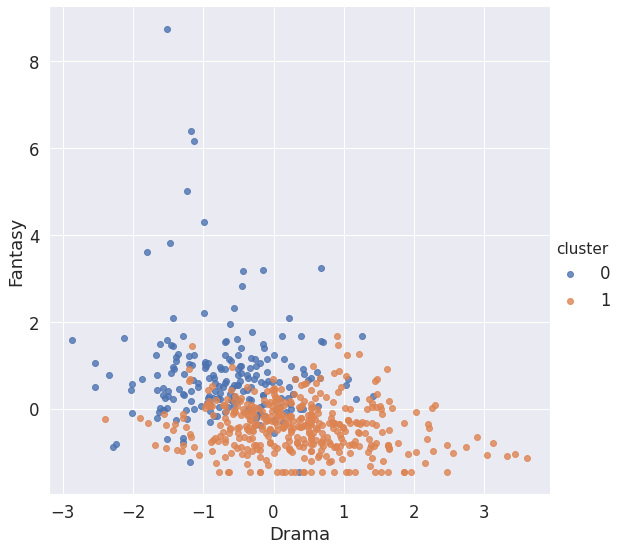

In [0]:
kmeans = KMeans(n_clusters=2, random_state=42)
all_genres = df_normalized_genre.columns[df_normalized_genre.columns != 'cluster']
genres = ['Drama', 'Fantasy']
df_normalized_genre['cluster'] = kmeans.fit_predict(df_normalized_genre[all_genres]).astype(int)
sns.lmplot(genres[0], genres[1], data=df_normalized_genre, hue='cluster', fit_reg=False, height=8)
plt.show()

Suppose we want to find to which cluster each user belongs based only on their taste for fantasy and drama. What would the decision surface look like?

KeyError: ignored

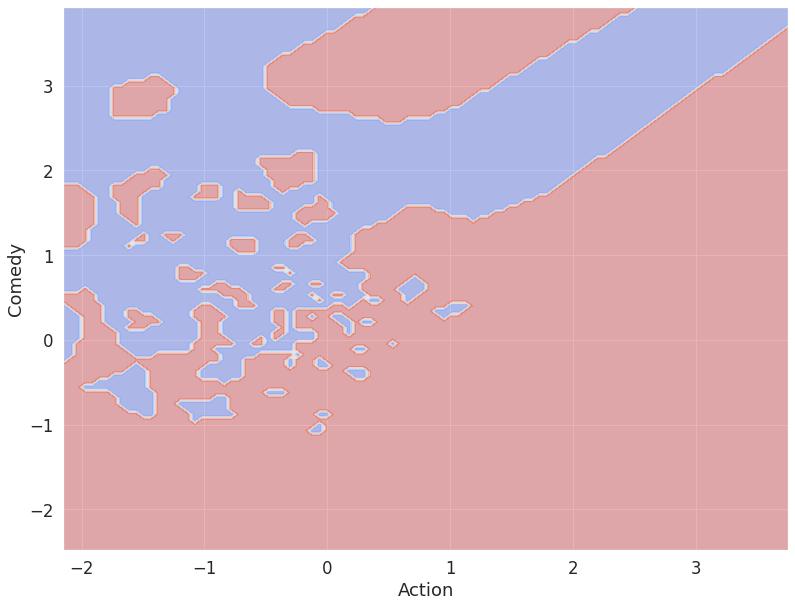

In [0]:
# Let's start by splitting the data
from sklearn.model_selection import train_test_split
X = df_normalized_genre[genres]
Y = df_normalized_genre['cluster']

for i, k in enumerate([1, 10, 100]):
    plt.figure(figsize=[13,10])
    model = KNeighborsClassifier(n_neighbors=k)
    Decision_Surface(X, genres[0], genres[1], Y, model)
    plt.title("K=" + str(k))
    plt.show()

Does this look familiar? How should we determine which k is the best one? You guessed it.  k is the complexity control "knob" for kNN -- we can decide its value in the same way we find the best complexity control parameters for other models.

In [0]:
for k in [1, 10, 20, 50, 100, 200, 400]:
    model = KNeighborsClassifier(n_neighbors=k)
    auc = cross_val_score(model, X, Y, scoring="roc_auc", cv=10).mean()
    print("AUC: {0} with K {1}".format(round(auc*100, 2), k))

AUC: 78.7 with K 1
AUC: 90.56 with K 10
AUC: 91.99 with K 20
AUC: 92.36 with K 50
AUC: 92.58 with K 100
AUC: 92.3 with K 200
AUC: 91.62 with K 400
